In [3]:
import numpy as np
import astropy.io.fits as fits
import astropy.units as u
from IPython.display import clear_output
import time
from pathlib import Path
import copy

import proper
proper.prop_use_fftw(DISABLE=True)
# proper.prop_fftw_wisdom( 1024 ) 

import roman_phasec_proper
roman_phasec_proper.copy_here()

import misc
from matplotlib.patches import Circle

data_dir = Path('/groups/douglase/kians-data-files/disk-processing')

wavelength_c = 575e-9*u.m
D = 2.3631*u.m
mas_per_lamD = (wavelength_c/D*u.radian).to(u.mas)

pixelscale_m_ref = 13e-6*u.m/u.pixel
pixelscale_lamD_ref = 1/2
wavelength_ref = 0.5e-6*u.m

npsf = 256     
psf_pixelscale_lamD = 0.1    
psf_pixelscale_mas = psf_pixelscale_lamD*mas_per_lamD/u.pix

polaxis = 10


(163,) [ 0.    0.05  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5   0.55
  0.6   0.65  0.7   0.75  0.8   0.85  0.9   0.95  1.    1.05  1.1   1.15
  1.2   1.25  1.3   1.35  1.4   1.45  1.5   1.55  1.6   1.65  1.7   1.75
  1.8   1.85  1.9   1.95  2.    2.05  2.1   2.15  2.2   2.25  2.3   2.35
  2.4   2.45  2.5   2.55  2.6   2.65  2.7   2.75  2.8   2.85  2.9   2.95
  3.    3.05  3.1   3.15  3.2   3.25  3.3   3.35  3.4   3.45  3.5   3.55
  3.6   3.65  3.7   3.75  3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5
  4.6   4.7   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7
  5.8   5.9   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9
  7.    7.1   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1
  8.2   8.3   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3
  9.4   9.5   9.6   9.7   9.9  10.1  10.3  10.5  10.7  10.9  11.1  11.3
 11.5  11.7  11.9  12.1  12.3  12.5  12.7  12.9  13.1  13.3  13.5  13.7
 13.9  14.1  14.3  14.5  14.7  14.9  15.1 ]
(24,) [

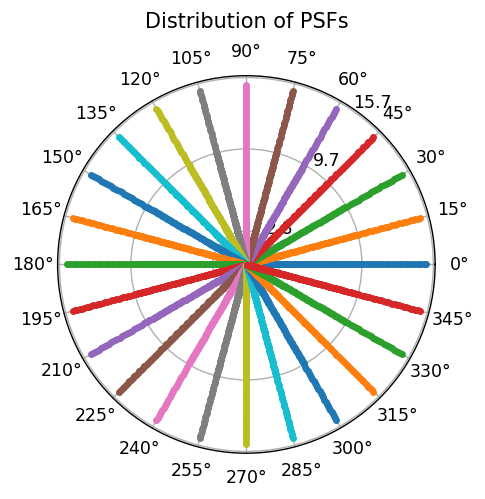

In [5]:
iwa = 2.8
owa = 9.7

sampling1 = 0.05
offsets1 = np.arange(0,iwa+1,sampling1)

sampling2 = 0.1
offsets2 = np.arange(iwa+1,owa,sampling2)

sampling3 = 0.2
offsets3 = np.arange(owa,15+sampling3,sampling3)

r_offsets = np.hstack([offsets1, offsets2, offsets3])
r_offsets_mas = r_offsets*mas_per_lamD
print(r_offsets.shape, r_offsets)

sampling_theta = 15
thetas = np.arange(0,360,sampling_theta)*u.deg
print(thetas.shape, thetas)

psfs_required = len(thetas)*len(r_offsets)
psfs_size_gb = psfs_required*(256**2)*8/1e9
time_required = 17*len(thetas)*len(r_offsets)/3600
print(psfs_required, psfs_size_gb, time_required)

r_offsets_hdu = fits.PrimaryHDU(data=r_offsets)
r_offsets_fpath = data_dir/'psfs'/'psf_radial_samples.fits'
r_offsets_hdu.writeto(r_offsets_fpath, overwrite=True)

thetas_hdu = fits.PrimaryHDU(data=thetas.value)
thetas_fpath = data_dir/'psfs'/'psf_theta_samples.fits'
thetas_hdu.writeto(thetas_fpath, overwrite=True)

import matplotlib.pyplot as plt
theta_offsets = []
for r in r_offsets[1:]:
    theta_offsets.append(thetas.to(u.radian).value)
theta_offsets = np.array(theta_offsets)
theta_offsets.shape

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, dpi=125)
ax.plot(theta_offsets, r_offsets[1:], '.')
# ax.set_rmax(2)
ax.set_rticks([iwa, owa, 15.7])  # Less radial ticks
ax.set_thetagrids(thetas.value)
ax.set_rlabel_position(55)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title('Distribution of PSFs', va='bottom')
plt.show()

In [6]:
nlam = 1
lam0 = 0.575
if nlam==1:
    lam_array = np.array([lam0])
else:
    bandwidth = 0.1
    minlam = lam0 * (1 - bandwidth/2)
    maxlam = lam0 * (1 + bandwidth/2)
    lam_array = np.linspace( minlam, maxlam, nlam )

dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm1.fits' )
dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + r'/examples/hlc_best_contrast_dm2.fits' )

options = {'cor_type':'hlc', # change coronagraph type to correct band
           'final_sampling_lam0':psf_pixelscale_lamD, 
           'source_x_offset':0,
           'source_y_offset':0,
           'use_fpm':1,
           'use_field_stop':1,
           'use_errors':1,
           'use_lens_errors':1,
           'use_hlc_dm_patterns':0,
           'use_dm1':1, 'dm1_m':dm1, 
           'use_dm2':1, 'dm2_m':dm2,
           'polaxis':polaxis,   
          }

Lambda = 5.7500E-07   Throughput = 1.00
Applying lens
Propagating to secondary
Applying lens
Propagating to POMA FOLD
Propagating to M3
Applying lens
Propagating to M4
Applying lens
Propagating to M5
Applying lens
Propagating to TT FOLD
Propagating to FSM
Propagating to OAP1
Applying lens
Propagating to FOCM
Propagating to OAP2
Applying lens
Propagating to DM1
Propagating to DM2
Propagating to OAP3
Applying lens
Propagating to FOLD_3
Propagating to OAP4
Applying lens
Propagating to PUPIL_MASK
Propagating to OAP5
Applying lens
Propagating to FPM
Propagating to OAP6
Applying lens
Propagating to LYOT STOP
Propagating to OAP7
Applying lens
Propagating to FIELD_STOP
Propagating to OAP8
Applying lens
Propagating to filter
Propagating to IMAGING LENS
Applying lens at IMAGING LENS lens #1
Propagating
Applying lens at IMAGING LENS lens #2
Propagating to IMAGE
Total elapsed time (seconds) =  11.9145


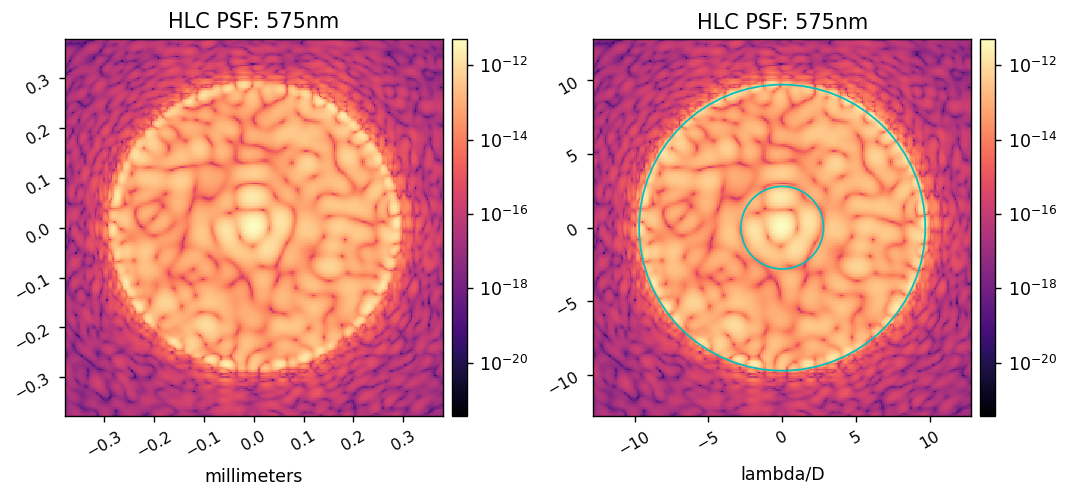

In [7]:
(wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=False, PASSVALUE=options)

psfs = np.abs(wfs)**2
psf_bb = np.sum(psfs, axis=0)/nlam
psf_pixelscale_m = pxscls_m[0]*u.m/u.pix

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.myimshow2(psf_bb, psf_bb, 'HLC PSF: 575nm', 'HLC PSF: 575nm',
               lognorm1=True, lognorm2=True, 
               pxscl1=psf_pixelscale_m.to(u.mm/u.pix), pxscl2=psf_pixelscale_lamD, patches2=patches)

In [10]:
len(r_offsets)

163

In [8]:
psfs_array = np.zeros( shape=( 2*len(thetas) + 1, npsf,npsf) )
psfs_array.shape, len(thetas)*2

((49, 256, 256), 48)

In [7]:
# psfs_array = np.zeros( shape=( (len(r_offsets)-1)*len(thetas) + 1, npsf,npsf) )
psfs_array = np.zeros( shape=( 4*len(thetas) + 1, npsf,npsf) )

count = 0
start = time.time()
for i,r in enumerate(r_offsets): 
    if i==5: break
    opts = []
    for j,th in enumerate(thetas):
        xoff = r*np.cos(th)
        yoff = r*np.sin(th)
        options.update( {'source_x_offset':xoff.value, 'source_y_offset':yoff.value} )
        opts.append(copy.copy(options))
        if r<r_offsets[1]: break
    
    (wfs, pxscls_m) = proper.prop_run_multi('roman_phasec', lam_array, npsf, QUIET=True, PASSVALUE=opts)

    psfs = np.abs(wfs)**2
    psf_pixelscale_m = pxscls_m[0]*u.m/u.pix
    
    if r<r_offsets[1]: psfs_array[0] = psfs[0]
    else: psfs_array[int( (count-1)*len(thetas) + 1 ):int( count*len(thetas) + 1 )] = psfs
    
    print(count, time.time()-start)
    count += 1

0 14.248669862747192
1 32.447818756103516
2 50.43216300010681
3 67.80534672737122
4 84.97946071624756


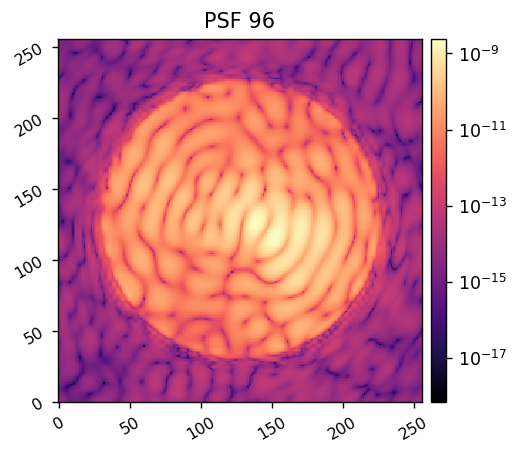

In [8]:
# misc.myimshow2(psfs_array[0], psfs_array[1])

for i in range(psfs_array.shape[0]):
    clear_output(wait=True)
    misc.myimshow(psfs_array[i], 'PSF {:d}'.format(i), lognorm=True)
    time.sleep(0.5)

In [17]:
hdr = fits.Header()
hdr['PXSCLAMD'] = psf_pixelscale_lamD
hdr.comments['PXSCLAMD'] = 'pixel scale in lam0/D per pixel'
hdr['PXSCLMAS'] = psf_pixelscale_mas.value
hdr.comments['PXSCLMAS'] = 'pixel scale in mas per pixel'
hdr['PIXELSCL'] = psf_pixelscale_m.value
hdr.comments['PIXELSCL'] = 'pixel scale in meters per pixel'
hdr['POLAXIS'] = polaxis
hdr.comments['POLAXIS'] = 'polaxis: defined by roman_phasec_proper'

psfs_hdu = fits.PrimaryHDU(data=psfs_array, header=hdr)

psfs_fpath = data_dir/'psfs'/'hlc_band1_polaxis{:d}_rtheta_2.fits'.format(polaxis)
psfs_hdu.writeto(psfs_fpath, overwrite=True)